In [47]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

En el siguiente proyecto se va a utilizar NLP con una serie de tweets relacionados con el Coronavirus, en concreto aquellos datados de marzo y abril de 2020. Se quiere clasificar estos tweets en negativos, neutros y positivos.

Tenemos los siguientes datos, obtenidos de Kaggle.

In [85]:
train = pd.read_csv("./archive/Corona_NLP.csv")
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


Solo nos interesaremos por ahora en dos variables concretas, la que contiene los tweets y la variable target.

Vemos la forma del dataset y comprobamos que no contiene valores nulos ni duplicados.

In [49]:
print(train.shape)
print(test.shape)

(41157, 6)
(3798, 6)


In [50]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [51]:
train['OriginalTweet'].astype(str)

0        @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1        advice Talk to your neighbours family to excha...
2        Coronavirus Australia: Woolworths to give elde...
3        My food stock is not the only one which is emp...
4        Me, ready to go at supermarket during the #COV...
                               ...                        
41152    Airline pilots offering to stock supermarket s...
41153    Response to complaint not provided citing COVI...
41154    You know its getting tough when @KameronWilds...
41155    Is it wrong that the smell of hand sanitizer i...
41156    @TartiiCat Well new/used Rift S are going for ...
Name: OriginalTweet, Length: 41157, dtype: object

Tenemos 5 categorías iniciales en la variable target, posteriormente se reducirán a 3
para facilitar la clasificación.

In [52]:
train.groupby('Sentiment').count()['OriginalTweet'].reset_index().sort_values(by='OriginalTweet',ascending=False)

,Sentiment,OriginalTweet
4,Positive,11422
2,Negative,9917
3,Neutral,7713
1,Extremely Positive,6624
0,Extremely Negative,5481


In [53]:
train.drop_duplicates(subset = 'OriginalTweet', inplace = True)
train.shape

(41157, 6)

No hay tweets duplicados.

## Análisis exploratorio

Un proyecto de NLP se presta bastante a realizar un buen análisis exploratorio para observar la distribución de palabras, caracteres, etc.

In [54]:
train['number_words'] = train.OriginalTweet.apply(lambda x: len(str(x).split()))
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,number_words
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,8
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,38
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,14
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,42
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,40


In [55]:
train['Sentiment'] = train['Sentiment'].replace({'Extremely Negative': 0,
                           'Negative': 0,
                           'Neutral': 1,
                           'Positive': 2,
                           'Extremely Positive': 2})

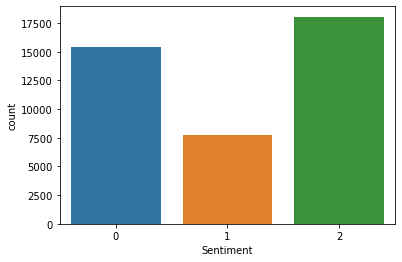

In [56]:
sns.countplot(x = 'Sentiment', data = train);

Analizamos el número de palabras por tweet.

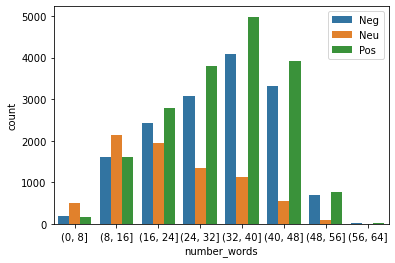

In [57]:
sns.countplot(x = pd.cut(train['number_words'],range(0,65,8)), hue = 'Sentiment', data = train);

plt.legend(labels=['Neg', 'Neu', 'Pos'])
plt.show()

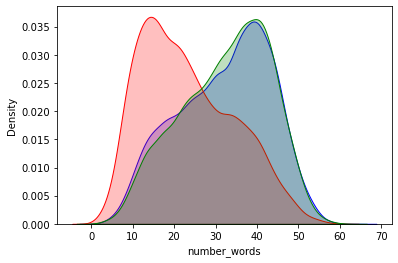

In [58]:
sns.kdeplot(x = train[train.Sentiment == 0]['number_words'], shade = True, color = 'blue');
sns.kdeplot(x = train[train.Sentiment == 1]['number_words'], shade = True, color = 'red');
sns.kdeplot(x = train[train.Sentiment == 2]['number_words'], shade = True, color = 'green');

Se observan distribuciones parecidas en los tweets positivos y negativos, distanciándose en cuanto a comportamiento de los tweets neutros. Cuantas más palabras contiene el tweet, menos probabilidad tiene de ser neutro.

Una vez analizado el número de palabras por tweets, sería interesante analizar el número de caracteres por tweet.

C:\Users\maiki\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\maiki\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\maiki\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdep

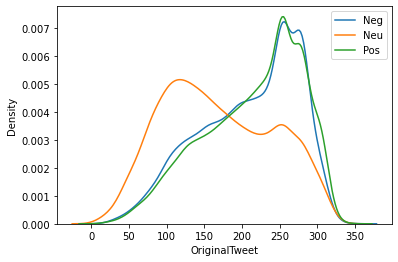

In [59]:
sns.distplot(train[train['Sentiment'] == 0]['OriginalTweet'].str.len(), hist = False);
sns.distplot(train[train['Sentiment'] == 1]['OriginalTweet'].str.len(), hist = False);
sns.distplot(train[train['Sentiment'] == 2]['OriginalTweet'].str.len(), hist = False);

plt.legend(labels=['Neg', 'Neu', 'Pos'])
plt.show()

La tendencia en cuanto al número de caracteres por tweet es parecida que en cuanto al número de palabras, distanciándose en este sentido los tweets neutros respecto a los negativos y positivos.

## Limpieza de corpus (preprocesado)

In [63]:
train.OriginalTweet.head(15)

0                                                      
1     advice talk neighbours family exchange phone n...
2     coronavirus australia woolworths give elderly ...
3     food stock one empty please panic enough food ...
4     ready go supermarket outbreak paranoid food st...
5     news regions first confirmed covid case came ...
6     cashier grocery store sharing insights prove c...
7                    supermarket today buy toilet paper
8     due covid retail store classroom atlanta open ...
9     corona preventionwe stop buy things cash use o...
10    month crowding supermarkets restaurants howeve...
11    due covid situation increased demand food prod...
12    caring community lets look less capable villa...
13    need stock food amazon deliver whatever need a...
14    adara releases covid resource center travel br...
Name: OriginalTweet, dtype: object

Se realiza un preprocesado de los tweets, eliminando enlaces, menciones de usuarios, signos, hashtags, tags de html y numeros.

In [64]:
links = re.compile("https\S+|www\.\S+")
menciones = re.compile("@\S+")
signos = re.compile("(\.)|(\/)|(#)|(\-)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)(/(\r\n|\n|\r))")
hashtags = re.compile("#\S+")
htmls = re.compile("<.*?>")
numeros = re.compile("\d+")

def preprocess_tweets(tweets):
    tweets = [links.sub("", tweet.lower()) for tweet in tweets]
    tweets = [menciones.sub("", tweet.lower()) for tweet in tweets]
    tweets = [hashtags.sub("", tweet.lower()) for tweet in tweets]
    tweets = [signos.sub("", tweet.lower()) for tweet in tweets]
    tweets = [htmls.sub("", tweet.lower()) for tweet in tweets]
    tweets = [numeros.sub("", tweet.lower()) for tweet in tweets]
    return tweets

train['OriginalTweet'] = preprocess_tweets(train['OriginalTweet'])
train['OriginalTweet']

0                                                         
1        advice talk neighbours family exchange phone n...
2        coronavirus australia woolworths give elderly ...
3        food stock one empty please panic enough food ...
4        ready go supermarket outbreak paranoid food st...
                               ...                        
41152    airline pilots offering stock supermarket shel...
41153    response complaint provided citing covid relat...
41154    know its getting tough rationing toilet paper...
41155             wrong smell hand sanitizer starting turn
41156    well newused rift going $ amazon rn although n...
Name: OriginalTweet, Length: 41157, dtype: object

### STOPWORDS

Una parte importante del preprocesado es la eliminación de los stopwords, palabras tales como conjunciones, preposiciones o tiempos verbales que no tendrán influencia alguna a la hora de clasificar.

In [65]:
from nltk.corpus import stopwords

english_stopwords = stopwords.words('english')
english_stopwords.append('i\'m')
english_stopwords.append('i\'ll')
english_stopwords.append('he\'s')
english_stopwords.append('i\'ll')
english_stopwords.append('he\'s')
english_stopwords.append('i\'d')
english_stopwords.append('we\'re')
english_stopwords.append('&amp')

def remove_stopwords(df):
     return " ".join([word for word in df.split() if word not in english_stopwords])

train['OriginalTweet'] = train['OriginalTweet'].apply(remove_stopwords)
train['OriginalTweet'].head(10)

0                                                     
1    advice talk neighbours family exchange phone n...
2    coronavirus australia woolworths give elderly ...
3    food stock one empty please panic enough food ...
4    ready go supermarket outbreak paranoid food st...
5    news regions first confirmed covid case came ...
6    cashier grocery store sharing insights prove c...
7                   supermarket today buy toilet paper
8    due covid retail store classroom atlanta open ...
9    corona preventionwe stop buy things cash use o...
Name: OriginalTweet, dtype: object

A continuación creo el corpus para cada categoría del target y hago un conteo de cada palabra.

In [66]:
from itertools import chain

def creacion_corpus(target):
    corpus=[]
    
    for x in train[train['Sentiment'] == target]['OriginalTweet'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

corpus_neg = creacion_corpus(0)
corpus_neu = creacion_corpus(1)
corpus_pos = creacion_corpus(2)
corpus_tot = list(chain(corpus_pos + corpus_neg + corpus_neu))

In [67]:
from collections import Counter

counter_neg = Counter(corpus_neg)
counter_pos = Counter(corpus_pos)
counter_neu = Counter(corpus_neu)
counter_tot = Counter(corpus_tot)

In [68]:
x_pos, y_pos, x_neg, y_neg, x_neu, y_neu, x_tot, y_tot = ([] for i in range(8))

for word, num in counter_pos.most_common()[:25]:
    x_pos.append(word)
    y_pos.append(num)
for word, num in counter_neg.most_common()[:25]:
    x_neg.append(word)
    y_neg.append(num)
for word, num in counter_neu.most_common()[:25]:
    x_neu.append(word)
    y_neu.append(num)
for word, num in counter_tot.most_common()[:25]:
    x_tot.append(word)
    y_tot.append(num)

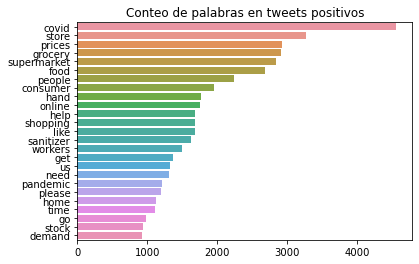

In [69]:
sns.barplot(x = y_pos, y = x_pos);
plt.title("Conteo de palabras en tweets positivos")
plt.show()

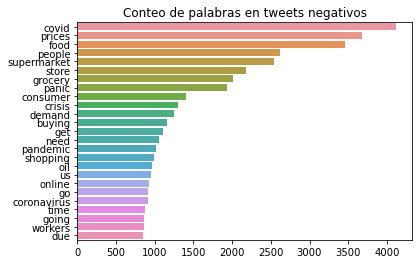

In [70]:
sns.barplot(x = y_neg, y = x_neg);
plt.title("Conteo de palabras en tweets negativos")
plt.show()

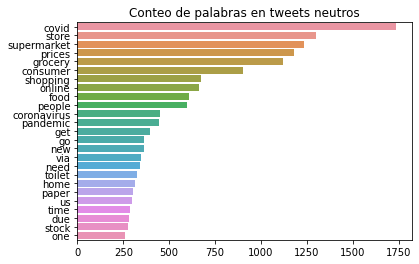

In [71]:
sns.barplot(x = y_neu, y = x_neu);
plt.title("Conteo de palabras en tweets neutros")
plt.show()

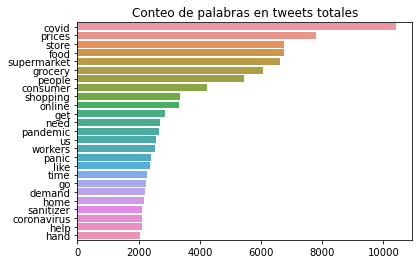

In [72]:
sns.barplot(x = y_tot, y = x_tot);
plt.title("Conteo de palabras en tweets totales")
plt.show()

Vemos que las principales palabras aparecen en las tres categorías (probaré más adelante Tfidf aquí para solucionar este problema), siendo algunas como 'crisis' o 'panic' propias de los tweets negativos y 'hand' o 'help' propias de los tweets positivos.

Creamos una nube de palabras en la que se verán las palabras más frecuentes.

In [73]:
from wordcloud import WordCloud

tot_neg, tot_neu, tot_pos, tot = ['' for i in range(4)]

for word in train[train['Sentiment'] == 0]['OriginalTweet']:
    tot_neg += ' '.join(str(word).split()) + ' '
for word in train[train['Sentiment'] == 1]['OriginalTweet']:
    tot_neu += ' '.join(str(word).split()) + ' '
for word in train[train['Sentiment'] == 2]['OriginalTweet']:
    tot_pos += ' '.join(str(word).split()) + ' '
for word in train['OriginalTweet']:
    tot += ' '.join(str(word).split()) + ' '

In [74]:
wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tot_neg)
wordcloud_neu = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tot_neu)
wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tot_pos)
wordcloud_tot = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tot)

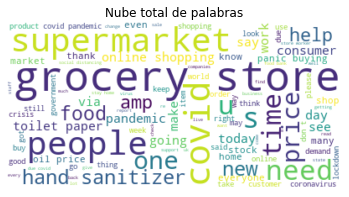

In [75]:
plt.figure()
plt.imshow(wordcloud_tot, interpolation="bilinear")
plt.title("Nube total de palabras")
plt.axis("off")
plt.show()

## Clasificación

A continuación, hacemos la clasificación de los tweets en cada categoría del target. Para ello, aplicamos distintos procedimientos propios de NLP como un Stemmer o Count Vectorizer, además de distintos modelos de Machine Learning.

### Stemmer

In [76]:
from nltk.stem.snowball import SnowballStemmer

def english_stemmer(x):
    stemmer = SnowballStemmer('english')
    return ' '.join([stemmer.stem(word) for word in x.split()])

train['OriginalTweet'] = train['OriginalTweet'].apply(english_stemmer)

In [77]:
train['OriginalTweet'].head()

0                                                     
1    advic talk neighbour famili exchang phone numb...
2    coronavirus australia woolworth give elder dis...
3    food stock one empti pleas panic enough food e...
4    readi go supermarket outbreak paranoid food st...
Name: OriginalTweet, dtype: object

In [78]:
train = train[['OriginalTweet', 'Sentiment']]

A continuación, vectorizo el dataset.

In [81]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

Para clasificar, se han probado modelos como Random Forest o XGBoost, obteniendo resultados un tanto mediocres. El algoritmo que mejor nos ha clasificado ha sido el SVC, que será el que utilicemos finalmente para clasificar. Queda pendiente para este proyecto utilizar embeddings y un algoritmo muy utilizado en Kaggle para NLP llamado Bert, creado por Google en 2018.

Hemos quitado algún parámetro del grid search que podría introducirse, debido a la gran cantidad de tiempo y recursos del ordenador que consume el proceso.

In [82]:
pipeline = Pipeline([
    ('vect', vectorizer),
    ('cls', LinearSVC())
])

parameters = {
    'vect__max_df': (0.5, 1.9),
    'vect__min_df': (10, 20,50),
    'vect__max_features': (500, 1000),
    'cls__C': (0.2, 0.5, 0.7),
}


grid_search = GridSearchCV(pipeline,
                          parameters,
                          cv = 5,
                          n_jobs = -1,
                          scoring = 'accuracy')

In [83]:
X = train['OriginalTweet']
y = train['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [508]:
grid_search.fit(X_train, y_train)

C:\Users\maiki\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('cls', LinearSVC())]),
             n_jobs=-1,
             param_grid={'cls__C': (0.2, 0.5, 0.7), 'vect__max_df': (0.5, 1.9),
                         'vect__max_features': (500, 1000),
                         'vect__min_df': (10, 20, 50)},
             scoring='accuracy')

In [511]:
model = grid_search.best_estimator_

y_pred = model.predict(X_test)

In [516]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

print(metrics.classification_report(y_test, y_pred))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           0       0.79      0.74      0.76      3062
           1       0.64      0.72      0.68      1553
           2       0.80      0.80      0.80      3617

    accuracy                           0.76      8232
   macro avg       0.75      0.75      0.75      8232
weighted avg       0.77      0.76      0.77      8232



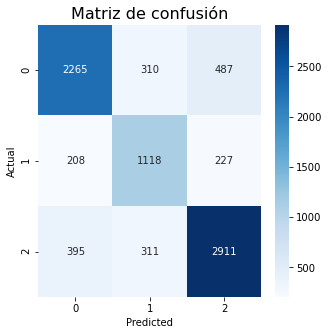

In [523]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
train = train.drop(columns=['Sentiment'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Matriz de confusión", size=16);

Hemos obtenido un accuracy para el test de 0.76, clasificando bastante mejor los tweets positivos y negativos que los neutros. Otro de los problemas parece ser que hay bastantes tweets negativos que los clasifica como positivos y viceversa, sin pasar por neutros.

Guardo el modelo por si tuviera que utilizarlo más adelante en una extensión del proyecto con más modelos y mejor preprocesamiento.

In [510]:
import pickle

with open('finished_model_train_test.model', "wb") as archivo_salida:
    pickle.dump(grid_search.best_estimator_, archivo_salida)

En resumen, se ha obtenido un clasificador decente pero fácilmente mejorable, quedándose pendiente la utilización de herramientas como Tfidf, Embeddings o el algoritmo Bert para una extensión del proyecto, con el objetivo de mejorar la clasificación del target.